### Make a prediction for the amount and predict the fraud use 

In [1]:
import pandas as pd
import numpy as np

# matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn for statistical data visualization
import seaborn as sns

# import machine learning models
from sklearn.linear_model import LinearRegression # import linear regression algorithm
from sklearn.ensemble import RandomForestRegressor # import random forest algorithm
from catboost import CatBoostRegressor, Pool # import catboost regressor
from lightgbm import LGBMRegressor # import lightgbm regressor
from xgboost import XGBRegressor # import xgboost regressor
from sklearn.neighbors import KNeighborsRegressor # import kneighbor regression

# import metric to measure quality of model
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# modules for data preprocessing and pipelines 
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE, SMOTENC
pd.options.mode.chained_assignment = None # to avoid SettingWithCopyWarning after scaling

# remove warnings
import warnings
warnings.filterwarnings('ignore')

print('Project libraries has been successfully been imported!')

Project libraries has been successfully been imported!


C:\Users\hotty\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# read the dataset
interview_fraud_df = pd.read_excel('C:/Users/hotty/Documents/Personal Projects/Machine Learning Projects/Machine-Learning-and-AI-Portfolio/data/raw/interview_fraud.xlsx').drop(['Unnamed: 0'],axis=1)
interview_fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,429,TRANSFER,2480757.90,C1150759357,0.00,0.00,C726473569,2624300.06,5105057.96,0,0
1,688,CASH_IN,376427.54,C328151886,5788301.18,6164728.72,C2098160906,447879.01,71451.47,0,0
2,226,DEBIT,3767.20,C1961446946,8020.21,4253.01,C1902968473,65244.29,69011.49,0,0
3,353,CASH_IN,82487.68,C1901396827,1827251.19,1909738.87,C1154031774,87935.41,5447.74,0,0
4,140,CASH_IN,50286.46,C1323292589,107512.00,157798.46,C78095483,158695.46,108409.00,0,0


### Data Exploration

In [3]:
# describe the data
interview_fraud_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,100000.0
mean,242.871670,1.807562e+05,8.454302e+05,8.665361e+05,1.110371e+06,1.235787e+06,0.001370,0.0
std,141.854832,6.324286e+05,2.904691e+06,2.939698e+06,3.463508e+06,3.785278e+06,0.036988,0.0
min,1.000000,1.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,155.000000,1.336421e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,237.000000,7.460686e+04,1.395950e+04,0.000000e+00,1.327902e+05,2.134465e+05,0.000000,0.0
75%,333.000000,2.083655e+05,1.078608e+05,1.453424e+05,9.452561e+05,1.108740e+06,0.000000,0.0
max,741.000000,5.680898e+07,3.470769e+07,3.469985e+07,3.215898e+08,3.555534e+08,1.000000,0.0


In [4]:
# check information about the data
interview_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
 9   isFraud         100000 non-null  int64  
 10  isFlaggedFraud  100000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.4+ MB


In [5]:
# find count of unique payment type
unique_type_percent = (interview_fraud_df['type'].value_counts() / interview_fraud_df['type'].value_counts().sum() * 100).tolist()   

# unique type
unique_type = interview_fraud_df['type'].value_counts().reset_index().rename(columns={'index': 'type', 'type': 'unique count'})
unique_type['percentage split (%)'] = ['{:.2f}'.format(x) for x in unique_type_percent]
unique_type

,type,unique count,percentage split (%)
0,CASH_OUT,35250,35.25
1,PAYMENT,33765,33.77
2,CASH_IN,21999,22.00
3,TRANSFER,8362,8.36
4,DEBIT,624,0.62


In [6]:
# group data by type
group_amount = interview_fraud_df.groupby('type').agg({'amount': 'sum'}).sort_values(by = 'amount', ascending = False).reset_index()
group_amount

,type,amount
0,TRANSFER,7.719746e+09
1,CASH_OUT,6.203608e+09
2,CASH_IN,3.709230e+09
3,PAYMENT,4.393905e+08
4,DEBIT,3.641137e+06


In [7]:
# check value count of isFlaggedFraud and isFraud
interview_fraud_df['isFlaggedFraud'].value_counts()

0    100000
Name: isFlaggedFraud, dtype: int64

In [8]:
# check value count of isFraud
interview_fraud_df['isFraud'].value_counts()

0    99863
1      137
Name: isFraud, dtype: int64

We see that the `isFlaggedFraud` feature contains 100000 zeros, so we need to drop that feature. Let's check correlation within features of the data

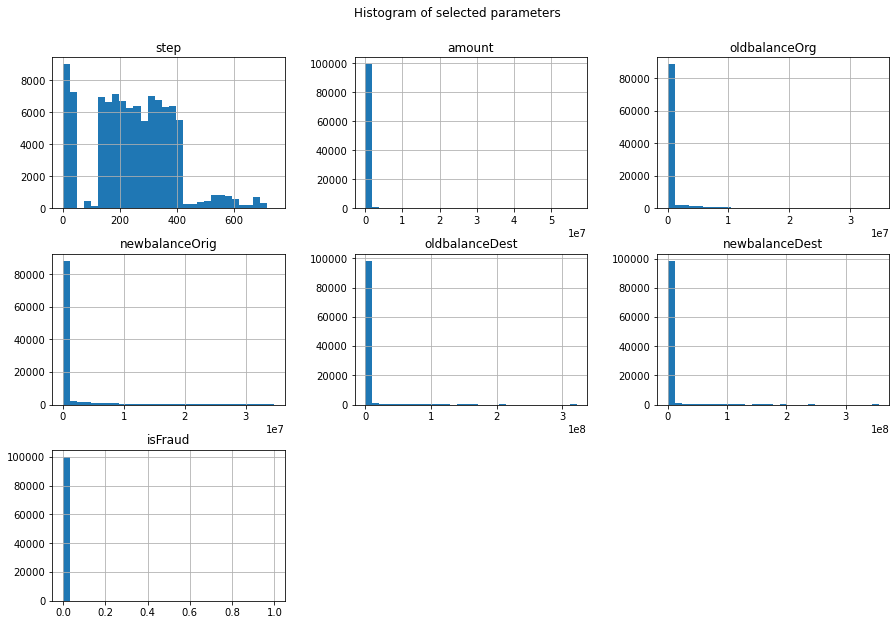

In [9]:
# Plot histogram of parameters
interview_fraud_df[['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of selected parameters', y=0.95);

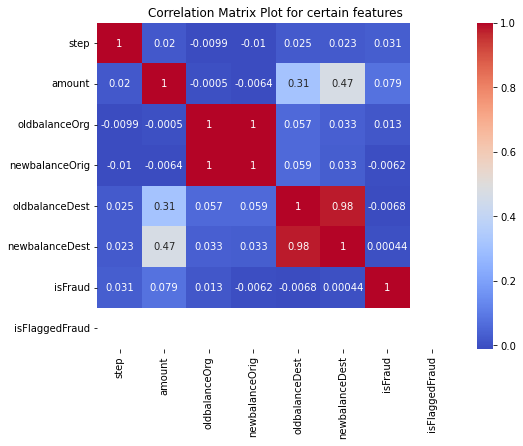

In [10]:
# correlation matrix of features
plt.figure(figsize=(8, 6))
corrMatrix = interview_fraud_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Plot for certain features')
plt.show();

We can see that there is high correlation between `oldbalanceDest` and `newbalanceDest` and also between `oldbalanceOrig` and `newbalanceOrig`.

### Modeling Process

In [11]:
# Extract the features and target variable
fraud_df = interview_fraud_df.copy()

# drop unimportant features
fraud_df = fraud_df.drop(['isFlaggedFraud'], axis=1)
fraud_df

# create features and target for predicting amount
amount_features = fraud_df.drop(['amount'], axis=1)
amount_target = fraud_df.amount

In [12]:
amount_features

,step,type,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,429,TRANSFER,C1150759357,0.00,0.00,C726473569,2624300.06,5105057.96,0
1,688,CASH_IN,C328151886,5788301.18,6164728.72,C2098160906,447879.01,71451.47,0
2,226,DEBIT,C1961446946,8020.21,4253.01,C1902968473,65244.29,69011.49,0
3,353,CASH_IN,C1901396827,1827251.19,1909738.87,C1154031774,87935.41,5447.74,0
4,140,CASH_IN,C1323292589,107512.00,157798.46,C78095483,158695.46,108409.00,0
...,...,...,...,...,...,...,...,...,...
99995,325,CASH_IN,C1022779033,1922566.21,2065016.26,C1273995743,281039.43,138589.37,0
99996,207,PAYMENT,C2136093503,0.00,0.00,M1633504341,0.00,0.00,0
99997,17,CASH_IN,C1563653287,1435957.81,1951894.77,C2008877599,984929.00,122279.41,0
99998,230,CASH_OUT,C628641476,22797.00,0.00,C806584414,642353.01,818808.37,0


In [13]:
amount_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   nameOrig        100000 non-null  object 
 3   oldbalanceOrg   100000 non-null  float64
 4   newbalanceOrig  100000 non-null  float64
 5   nameDest        100000 non-null  object 
 6   oldbalanceDest  100000 non-null  float64
 7   newbalanceDest  100000 non-null  float64
 8   isFraud         100000 non-null  int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 6.9+ MB


In [14]:
# split categorical columns based on cardinality
def split_categorical_features(df, n=10):
    """
    Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
    """
    high_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() > n and df[cname].dtype == 'object']
    low_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() < n and df[cname].dtype == 'object']
    return low_cardinality_cols, high_cardinality_cols

# function to preprocess data
def data_preprocessing_pipeline(df):
    # numerical and categorical features
    categorical_cols = [cname for cname in df.columns if df[cname].dtype == 'object']  # categorical columns 
    numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'int32', 'float64', 'float32']]  # numerical columns

    # convert categorical features to string 
    df[categorical_cols] = df[categorical_cols].astype('object')
    
    # train set features split by cardinality
    categorical_low, categorical_high = split_categorical_features(df)
    
    # changing the feature to a category type for ordinal encoding
    for i in categorical_high:
        df[i] = df[i].astype('category')
        df[i] = df[i].cat.codes
    
    # preprocessing pipelines
    # continuos pipeline
    numeric_transformer = Pipeline(
        steps=[('scaler', StandardScaler())]
    )

    # categorical low pipeline
    categorical_transformer_low = Pipeline(
        steps=[
            ('encoding', OrdinalEncoder())
        ]
    )

    # categorical high pipeline
    categorical_transformer_high = Pipeline(
        steps=[
            ('encoding', OrdinalEncoder()),
            ('scaler', StandardScaler())
        ]
    )
    
    # create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_cols),
            ("categorical_low", categorical_transformer_low, categorical_low),
            ("categorical_high", categorical_transformer_high, categorical_high),
        ]
    )
    
    return preprocessor

In [15]:
# function to extract feature names from pipeline
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names_out()] 
        else:
            return estimator.get_feature_names_out(feature_in)  
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

In [16]:
# preprocess dataset for modeling
preprocessor = data_preprocessing_pipeline(amount_features)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['step', 'oldbalanceOrg', 'newbalanceOrig',
                                  'oldbalanceDest', 'newbalanceDest',
                                  'isFraud']),
                                ('categorical_low',
                                 Pipeline(steps=[('encoding',
                                                  OrdinalEncoder())]),
                                 ['type']),
                                ('categorical_high',
                                 Pipeline(steps=[('encoding', OrdinalEncoder()),
                                                 ('scaler', StandardScaler())]),
                                 ['nameOrig', 'nameDest'])])

In [17]:
# final preprocessed data pipeline
preprocessed_amount_df = preprocessor.fit_transform(amount_features)
preprocessed_amount = pd.DataFrame(preprocessed_amount_df, columns=get_ct_feature_names(preprocessor))
preprocessed_amount.head()

,step,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type,nameOrig,nameDest
0,1.312111,-0.291058,-0.294772,0.437111,1.022194,-0.037039,4.0,-1.460836,0.203279
1,3.137930,1.701694,1.802301,-0.191279,-0.307597,-0.037039,0.0,0.537979,-0.433717
2,-0.118937,-0.288297,-0.293325,-0.301755,-0.308242,-0.037039,2.0,-0.000973,-0.658161
3,0.776349,0.338014,0.354869,-0.295204,-0.325034,-0.037039,0.0,-0.110164,-1.520880
4,-0.725193,-0.254045,-0.241093,-0.274774,-0.297834,-0.037039,0.0,-1.144559,0.264463


### Split data into 60% training, 20% validation and 20% testing sets
Here we split the data into training, validation and testing sets in the ratio 60:20:20 respectively.

In [18]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_amount, amount_target, test_size=0.20, random_state=12345)

# split train data into validation and train 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state = 12345) # 0.25 * 0.80 = 0.20 for validation size

# display the shape of the split dataset
print('The train set now contains {}'.format(X_train.shape[0]) + ' dataset representing 60% of the data') 
print('The valid set now contains {}'.format(X_valid.shape[0]) + ' dataset representing 20% of the data')
print('The test set now contains {}'.format(X_test.shape[0]) + ' dataset representing 20% of the data')

The train set now contains 60000 dataset representing 60% of the data
The valid set now contains 20000 dataset representing 20% of the data
The test set now contains 20000 dataset representing 20% of the data


### Train Linear Regressor

In [19]:
# function to train model and make predictions
def train_linear_model(X_train, y_train):
    """This function trains a linear model"""
    global lr_model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
def linear_regressor_prediction(X_test, y_test):
    """
    This function is used to make prediction 
    using a linear regression model
    """
    lr_pred = lr_model.predict(X_test)
    # rmse for linear model
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    print("\033[1m" + 'RMSE using Linear Regression' + "\033[0m")
    print('RMSE: {:.3f}'.format(lr_rmse))
    print()

In [20]:
%%time
# train linear model
train_linear_model(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 22.9 ms


In [21]:
%%time
# make predictions with linear regression for validation data
linear_regressor_prediction(X_valid, y_valid)

RMSE using Linear Regression
RMSE: 389544.893

CPU times: total: 0 ns
Wall time: 3.99 ms


### Train KNeighbors Regressor

In [22]:
%%time
# hyperparameter optimization for KNeighbors regression

# define hyperparameters to tune
knn_grid = {'n_neighbors' : range(1,5,1),
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            }
# define the model 
knn_regr = KNeighborsRegressor()

# define the grid search
grid_search_knn = GridSearchCV(
    estimator = knn_regr, 
    param_grid = knn_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5, 
    n_jobs = 1
)
# execute search
grid_search_knn.fit(X_train, y_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_knn.best_params_))

The best hyperparameters are: {'algorithm': 'auto', 'n_neighbors': 4}
CPU times: total: 4min 25s
Wall time: 2min 50s


In [23]:
# function to train model and make predictions
def train_KNeighbors_regressor(X_train, y_train):
    """This function trains a KNeighbors regressor model"""
    global knn_model
    # build the model
    knn_model = KNeighborsRegressor(**grid_search_knn.best_params_)
    knn_model.fit(X_train, y_train) # train the model 
    
def KNeighbors_regressor_prediction(X_test, y_test):
    """
    This function is used to make prediction 
    using the KNeighbors regression model
    """
    knn_pred = knn_model.predict(X_test)
    # determine RMSE for KNeighbors regressor
    knn_rmse = np.sqrt(mean_squared_error(y_test, knn_pred))
    print("\033[1m" + 'RMSE using KNeighbors Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(knn_rmse))
    print()

In [24]:
%%time
# train KNeighbors regressor model
train_KNeighbors_regressor(X_train, y_train)

CPU times: total: 188 ms
Wall time: 185 ms


In [25]:
%%time
# make predictions with KNeighbors regressor for validation data
KNeighbors_regressor_prediction(X_valid, y_valid)

RMSE using KNeighbors Regressor
RMSE: 345467.674

CPU times: total: 3.2 s
Wall time: 3.21 s


### Train LightGBM Regressor

In [26]:
%%time
# hyperparameter optimization for LightGBM regression

# define hyperparameters to tune
lgbm_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 500],
             'num_leaves': [5, 10, 20, 31]
            }
# define the model 
lgbm_regr = LGBMRegressor(random_state = 12345)

# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5, 
    n_jobs = 1
)
# execute search
grid_search_lgbm.fit(X_train, y_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 5}
CPU times: total: 12min 22s
Wall time: 2min 1s


In [27]:
# function to train model and make predictions
def train_lightGBM_regressor(X_train, y_train):
    """This function trains a LightGBM regressor model"""
    global lgbm_model
    # build the model
    lgbm_model = LGBMRegressor(**grid_search_lgbm.best_params_)
    lgbm_model.fit(X_train, y_train) # train the model 
    
def lightGBM_regressor_prediction(X_test, y_test):
    """
    This function is used to make prediction 
    using the lightGBM regression model
    """
    lgbm_pred = lgbm_model.predict(X_test)
    # determine RMSE for LightGBM regressor
    lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
    print("\033[1m" + 'RMSE using LightGBM Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(lgbm_rmse))
    print()
    # feature importance from LightGBM regression 
    sorted_feature_importance = lgbm_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(X_train.columns[sorted_feature_importance], 
             lgbm_model.feature_importances_[sorted_feature_importance], 
             color='turquoise')
    plt.xlabel("LightGBM Feature Importance")

In [28]:
%%time
# train lightGBM regressor model
train_lightGBM_regressor(X_train, y_train)

CPU times: total: 4.11 s
Wall time: 641 ms


RMSE using LightGBM Regressor
RMSE: 338441.072

CPU times: total: 812 ms
Wall time: 151 ms


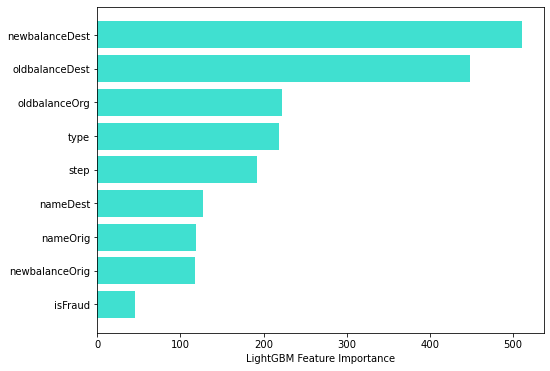

In [29]:
%%time
# make predictions with lightGBM regressor for validation data
lightGBM_regressor_prediction(X_valid, y_valid)

### Train XGBoost Regressor

In [30]:
%%time
# hyperparameter optimization for XGBoost

# define hyperparameters to tune
xgb_grid = {'learning_rate': [0.001, 0.1, 0.3], 
            'max_depth': [4, 6, 10]
           }
# define the model 
xgb_regr = XGBRegressor(random_state = 12345)

# define the grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_regr, 
    param_grid = xgb_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 5, 
    n_jobs = 1
)
# execute search
grid_search_xgb.fit(X_train, y_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_xgb.best_params_))

The best hyperparameters are: {'learning_rate': 0.3, 'max_depth': 4}
CPU times: total: 20min 32s
Wall time: 3min 23s


In [31]:
# function to train model and make predictions
def train_xgboost_regressor(X_train, y_train):
    """This function trains a XGBoost regressor model"""
    global xgb_model
    # build the model
    xgb_model = XGBRegressor(**grid_search_xgb.best_params_)
    xgb_model.fit(X_train, y_train) # train the model 
    
def xgboost_regressor_prediction(X_test, y_test):
    """
    This function is used to make prediction 
    using the XGBoost regression model
    """
    xgb_pred = xgb_model.predict(X_test)
    # determine RMSE for XGBoost regressor
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print("\033[1m" + 'RMSE using XGBoost Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(xgb_rmse))
    print()
    # feature importance from XGBoost regression 
    sorted_feature_importance = xgb_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(X_train.columns[sorted_feature_importance], 
             xgb_model.feature_importances_[sorted_feature_importance], 
             color='turquoise')
    plt.xlabel("XGBoost Feature Importance")

In [32]:
%%time
# train xgboost regressor model
train_xgboost_regressor(X_train, y_train)

CPU times: total: 19.5 s
Wall time: 3.18 s


RMSE using XGBoost Regressor
RMSE: 284319.088

CPU times: total: 891 ms
Wall time: 184 ms


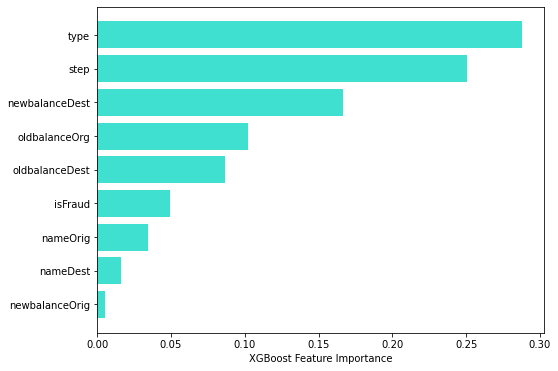

In [33]:
%%time
# make predictions with xgboost regressor for validation data
xgboost_regressor_prediction(X_valid, y_valid)

### Train Random Forest Regressor

In [35]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "n_estimators" : [50, 100],
    "max_depth" : [None, 2, 10]
}
# define the model 
regressor = RandomForestRegressor(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring="neg_mean_squared_error", cv=5)
# execute search
grid_search_rf.fit(X_train, y_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))

The best hyperparameters are: {'max_depth': None, 'n_estimators': 50}
CPU times: total: 6min 58s
Wall time: 6min 59s


In [36]:
# function to train model and make predictions
def train_random_forest(X_train, y_train):
    """This function trains a random forest model"""
    global rf_model
    # build the model
    rf_model = RandomForestRegressor(**grid_search_rf.best_params_)
    rf_model.fit(X_train, y_train) # train the model 
    
def random_forest_regressor_prediction(X_test, y_test):
    """
    This function is used to make prediction 
    using a random forest regression model
    """
    rf_pred = rf_model.predict(X_test)
    # determine RMSE for random forest regressor
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    print("\033[1m" + 'RMSE using Random Forest Regressor' + "\033[0m")
    print('RMSE: {:.3f}'.format(rf_rmse))
    print()
    # feature importance from random forest regression 
    sorted_feature_importance = rf_model.feature_importances_.argsort()
    plt.figure(figsize=(8,6))
    plt.barh(X_train.columns[sorted_feature_importance], 
             rf_model.feature_importances_[sorted_feature_importance], 
             color='turquoise')
    plt.xlabel("Random Forest Feature Importance")

In [37]:
%%time
# train random forest model
train_random_forest(X_train, y_train)

CPU times: total: 20.8 s
Wall time: 20.8 s


RMSE using Random Forest Regressor
RMSE: 277164.455

CPU times: total: 375 ms
Wall time: 381 ms


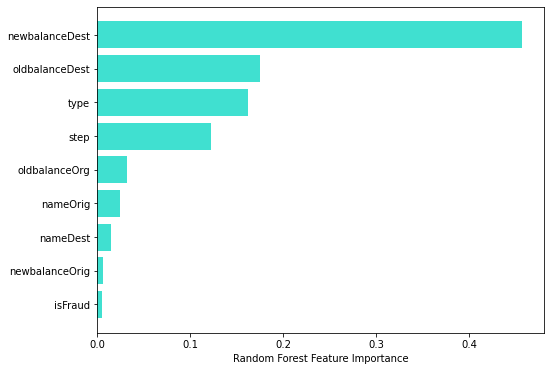

In [38]:
%%time
# make predictions with random forest regressor for validation data
random_forest_regressor_prediction(X_valid, y_valid)

### Model testing

The XGBoost regressor is chosen as the model for the final testing since it gave the lowest RMSE and have the lowest tuning and prediction time.

RMSE using XGBoost Regressor
RMSE: 278339.832



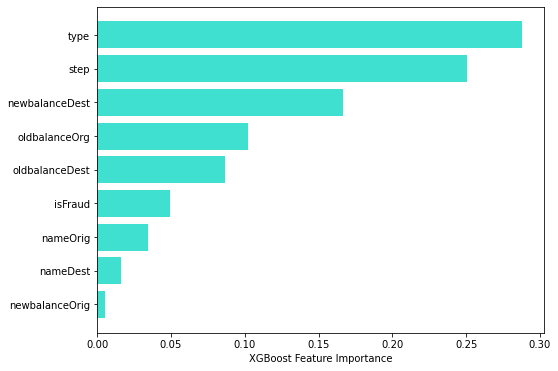

In [42]:
# make predictions with XGBoost regressor for test data
xgboost_regressor_prediction(X_test, y_test)

### Conclusion

We explored the data and studied the general information about the data. We observed that the data consisted of 100000rows and 11 features. looking through the features we observed that there are 3 categorical features and 7 numberical features. We explored the data by finding the unique count of the `type` features and grouped `type` by the amount to see the amount grouped by type of transaction. We checked for correlation within the data and observed that there is high correlation between `oldbalanceDest` and `newbalanceDest` and also between `oldbalanceOrig` and `newbalanceOrig`. We also observed that `isFlaggedFraud` contains just '0' as its unique value. Since we don't have any more information about the data, we dropped that `isFlaggedFraud` feature. 

We passed the data through a preprocessing pipeline and split the data into 60% training, 20% testing and 20% validation sets. We trained the `linear regressor`, `KNeighbors regressor`, `lightGBM regressor`, `Random Forest regressor`, and the `XGBoost regressor` on the train set, tuned the model and predicted on the test set. We observed that the `XGBoost regressor` and the `Random Forest regressor` performed better for this data. using the `XGBoost regressor` as the final model, we obtained an RMSE score of 278339.832 on the test set. The `XGBoost regressor` should that the most important factor affecting the predicted amount is the `type`, `step`, and `newbalanceDest`. 

Assuming time constraint and computational resources is not a factor, dropping either one of `oldbalanceDest` and `newbalanceDest` and either one of `oldbalanceOrig` and `newbalanceOrig` could lead to improved model performance since either of those features are highly correlated to one another. 